In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ROOT = "C:/Users/Emile/Documents/Polytechnique/4A/ParisSaclay/Stage/spinal_cross_species_V1/"


In [2]:
# load co-integrated mouse data
merged = sc.read_h5ad(ROOT + "data/co_integrated_data/mouse_neurons+skinnider+knaf14.h5ad")

c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\anndata\compat\__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [3]:
merged

AnnData object with n_obs × n_vars = 28221 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_variance', 'vf_vst_counts.KNAF3_variance.expected', 'vf_vst_

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [5]:
np.unique(merged.obs['orig.ident'])

array(['BOUV5', 'GSE7474501', 'GSM7474503', 'KATHE', 'KNAF14', 'KNAF3',
       'KNAF4', 'MATSON'], dtype=object)

In [6]:
merged.obs['training_labels'].groupby(merged.obs['orig.ident']).value_counts()

orig.ident  training_labels
BOUV5       -1.0               1417
GSE7474501  -1.0               4260
GSM7474503  -1.0               6784
KATHE       -1.0               2331
KNAF14      -1.0               6039
KNAF3        0.0               3265
KNAF4        1.0               1820
MATSON      -1.0               2305
Name: count, dtype: int64

In [7]:
# merged.obs['orig.ident'] = merged.obs['orig.ident'].apply(lambda x: 'BOUV5' if x == 0 else 'KATHE' if x == 1 else 'KNAF3' if x == 2 else 'KNAF4' if x == 3 else 'MATSON' if x == 4 else 'TREVISAN')

In [8]:
# # Mark unnassigned to -1, and knaf3-4 that are not labeled 1 to 0
# merged.obs['labels'] = -1
# merged.obs.loc[merged.obs['orig.ident'] == 'KNAF3-4_En1Sun1NeuN-GFP', 'labels'] = 0
# merged.obs.loc[merged.obs['GFP'] > 0, 'labels'] = 1

In [9]:
merged.obs['training_labels'].value_counts()

training_labels
-1.0    23136
 0.0     3265
 1.0     1820
Name: count, dtype: int64

In [10]:
merged.obs['training_labels'] = merged.obs['training_labels'].astype('category')

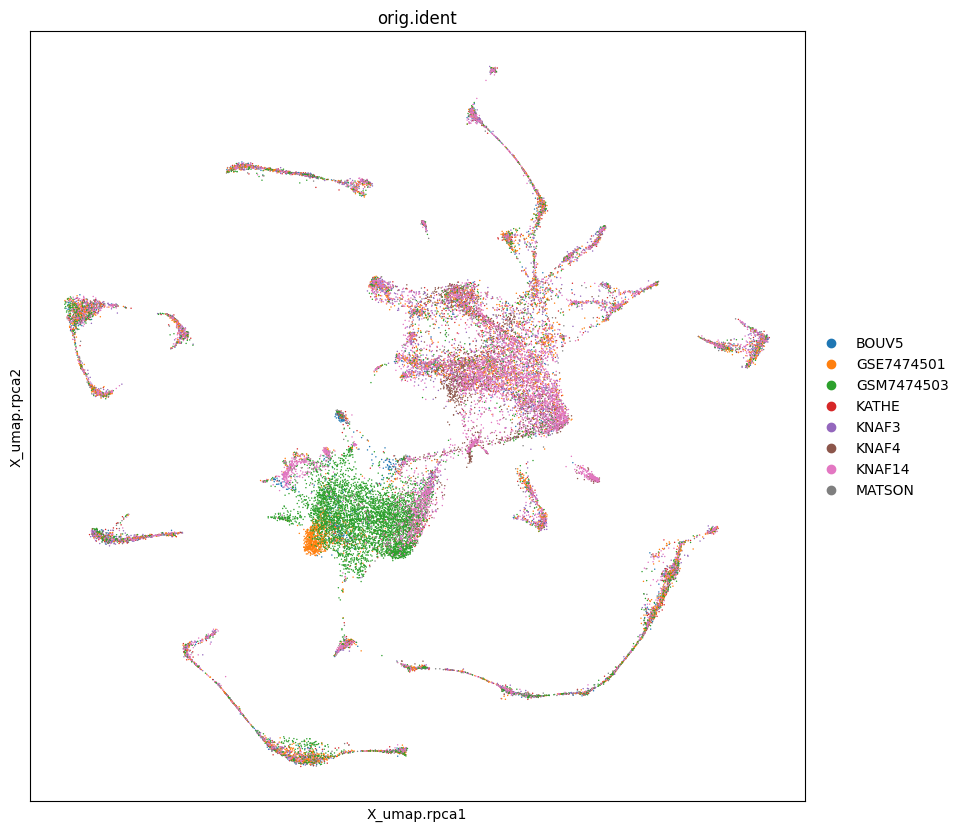

In [11]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, basis='X_umap.rpca', color='orig.ident', ax = ax)

In [12]:
# Create annotation in obs to prepare for training
merged.obs['annotation']  = merged.obs['training_labels'].apply(lambda x: 'GFP+' if x == 1 else 'GFP-' if x == 0 else 'Unassigned')

In [14]:
merged.uns['annotation_colors'] = ['yellow', 'red', 'blue']

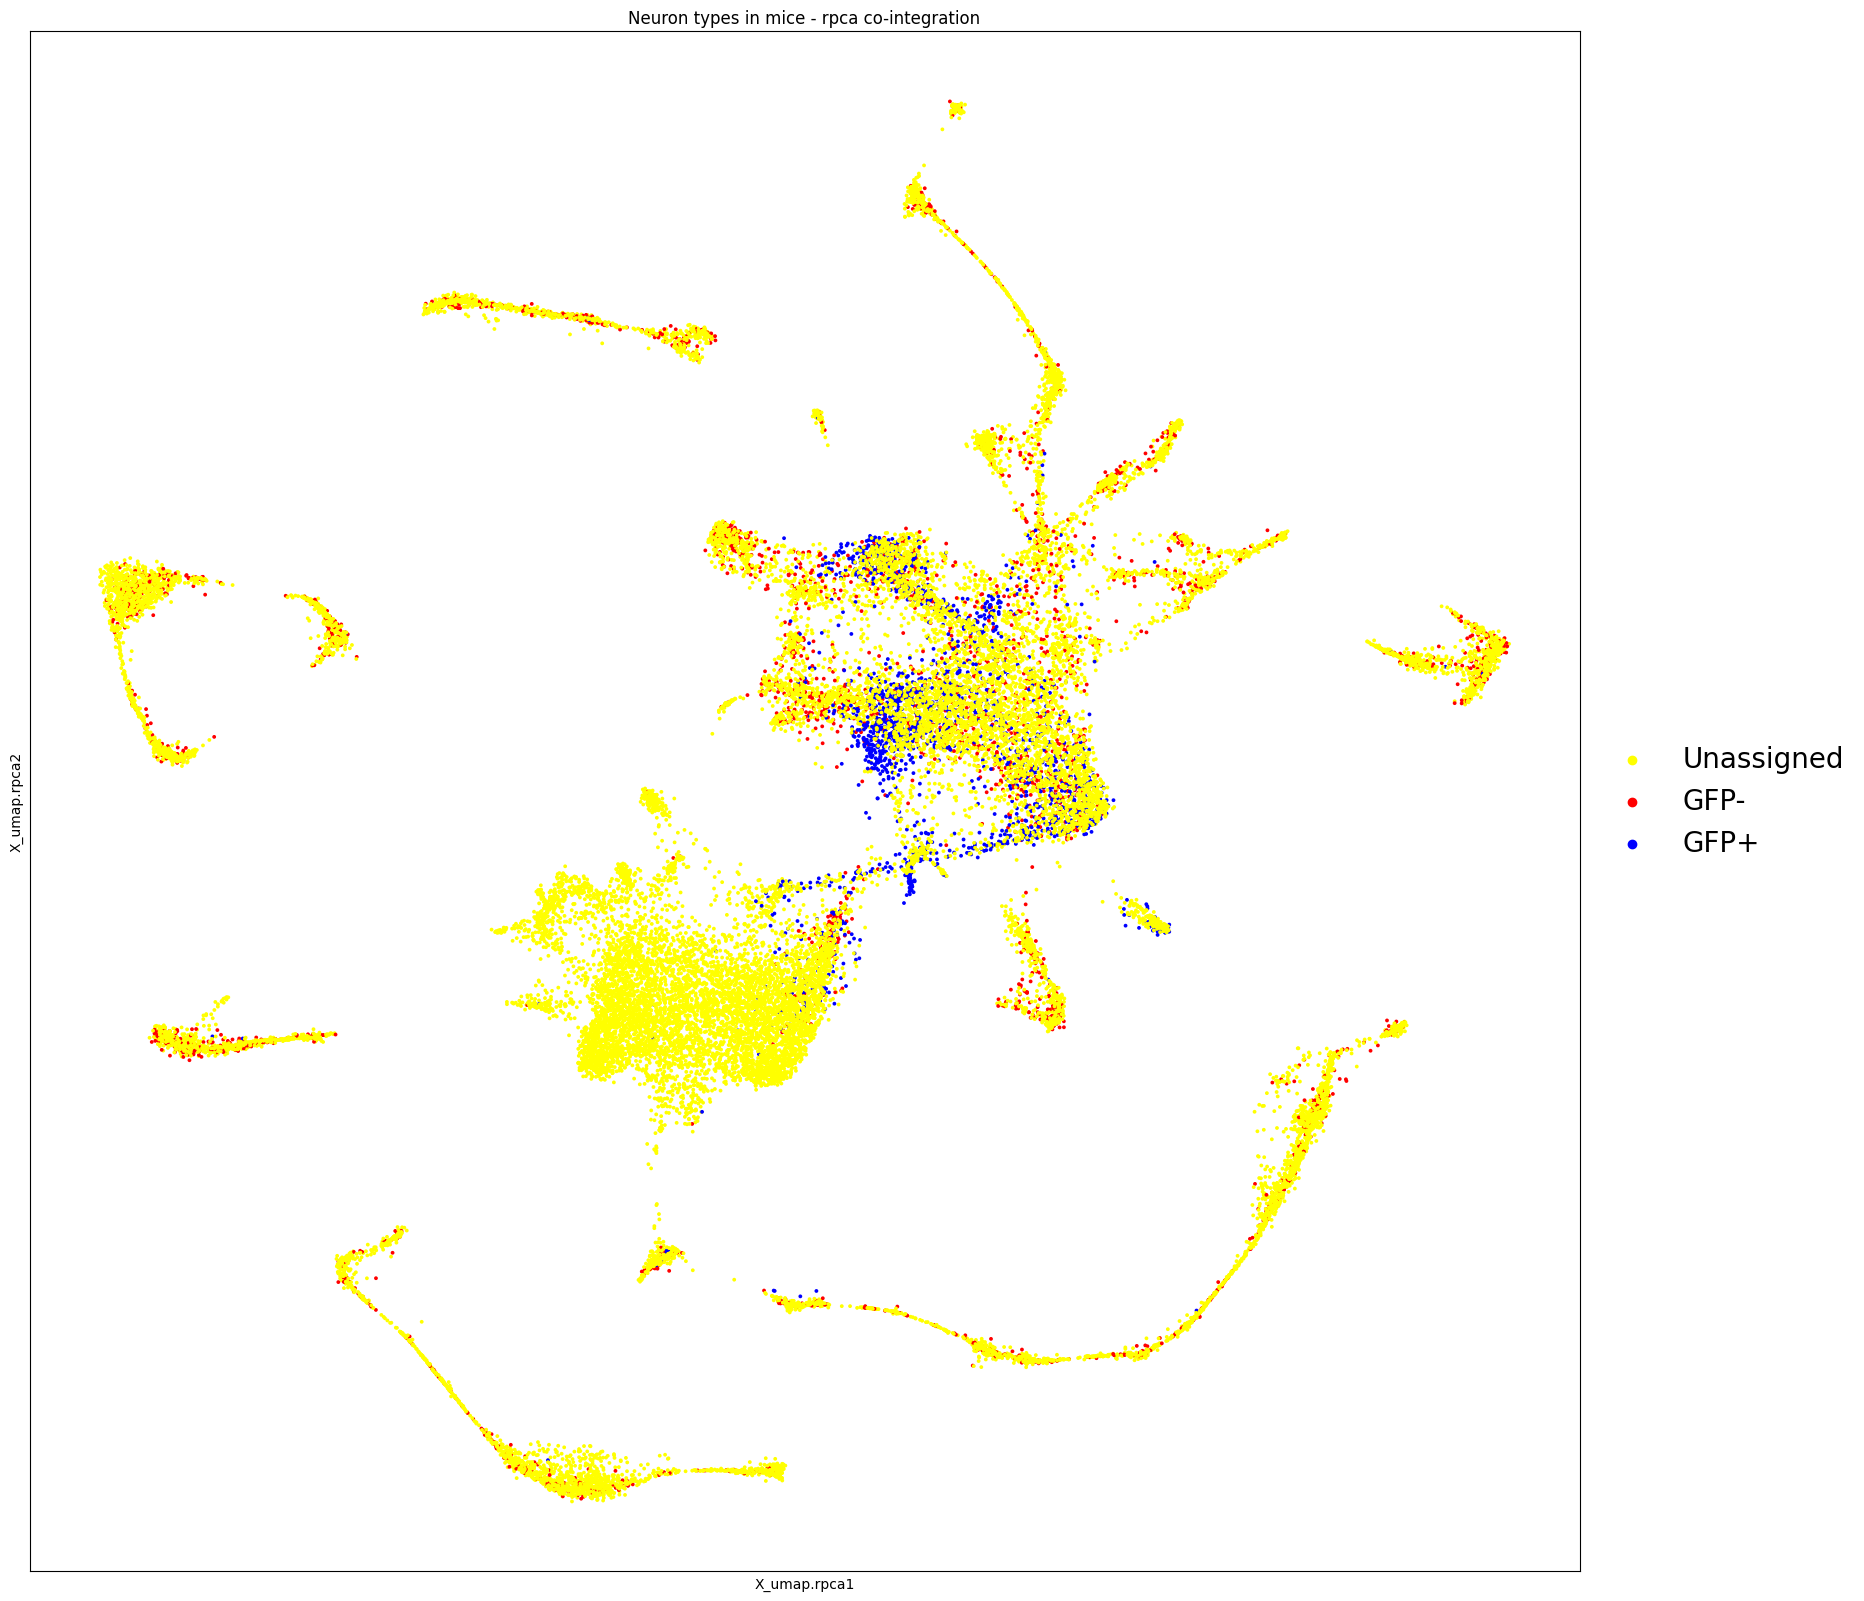

In [15]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
sc.pl.embedding(merged, basis='X_umap.rpca', color='annotation', title='Neuron types in mice - rpca co-integration', ax = ax, size = 30 , save = '_mouse_cointegration_all_neurons.svg', legend_fontsize=20)

In [16]:
merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_20644\2191423095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  annotation
BOUV5       Unassigned    1417
            GFP-             0
            GFP+             0
GSE7474501  Unassigned    4260
            GFP-             0
            GFP+             0
GSM7474503  Unassigned    6784
            GFP-             0
            GFP+             0
KATHE       Unassigned    2331
            GFP-             0
            GFP+             0
KNAF3       GFP-          3265
            Unassigned       0
            GFP+             0
KNAF4       GFP+          1820
            Unassigned       0
            GFP-             0
KNAF14      Unassigned    6039
            GFP-             0
            GFP+             0
MATSON      Unassigned    2305
            GFP-             0
            GFP+             0
Name: count, dtype: int64

## Outlier detection in the knaf3-4 neurons

In [537]:
# Outlier detection model
# Isolation Forest
from sklearn.ensemble import IsolationForest

# Extract knaf4 neurons
knaf4 = merged[merged.obs['training_labels'] == 1]

# Detect outliers
clf = IsolationForest(contamination=0.05)

# Train model
clf.fit(knaf4.X)

# Predict outliers
outliers = clf.predict(knaf4.X)

In [538]:
# Count outliers
unique, counts = np.unique(outliers, return_counts=True)

print(dict(zip(unique, counts)))

{np.int64(-1): np.int64(91), np.int64(1): np.int64(1729)}


C:\Users\Emile\AppData\Local\Temp\ipykernel_10900\2320479696.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  knaf4.obs['outliers'] = outliers


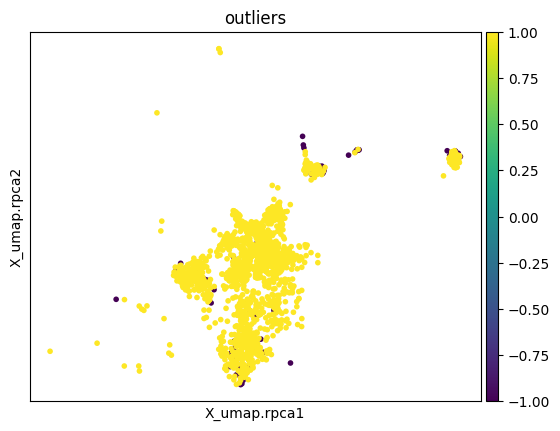

In [297]:
# Plot outliers in UMAP
knaf4.obs['outliers'] = outliers

sc.pl.embedding(knaf4, basis='X_umap.rpca', color='outliers')

No outliers

# Train classification model

In [17]:
# Split data into reference and query datasets
ref = merged[merged.obs['training_labels'] != -1]

In [18]:
ref.obs['training_labels'].value_counts()

training_labels
0.0    3265
1.0    1820
Name: count, dtype: int64

In [19]:
ref.uns['annotation_colors'] = ['red', 'green']

C:\Users\Emile\AppData\Local\Temp\ipykernel_20644\182440358.py:1: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ref.uns['annotation_colors'] = ['red', 'green']


In [20]:
# Compute umap representation
sc.neighbors.neighbors(ref)
sc.tl.umap(ref)

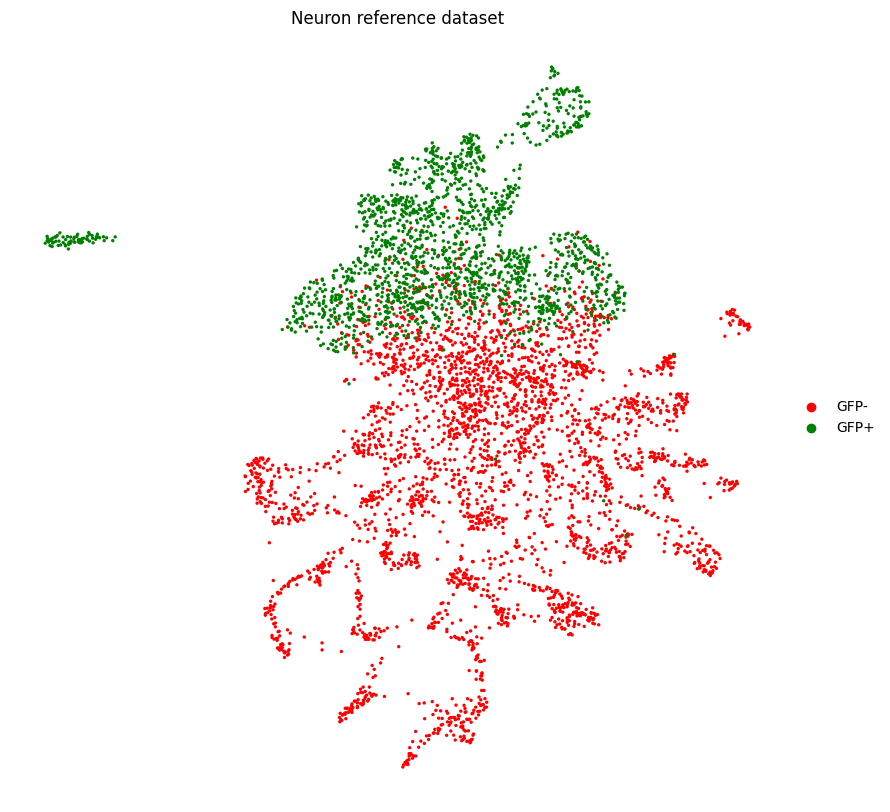

In [21]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(ref, basis='umap', color='annotation', title='Neuron reference dataset', ax = ax, save = '_mouse_ref.svg', frameon=False)

In [22]:
# Use the whole expression array for features
X = np.array(ref.X)
y = ref.obs['training_labels']
n_classes = len(np.unique(y))

In [23]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [24]:
print("ref data shape: ", X.shape)
print("train data shape: ", X_train.shape)
print("test data shape: ", X_test.shape)
print("number of classes: ", n_classes)

ref data shape:  (5085, 2000)
train data shape:  (4068, 2000)
test data shape:  (1017, 2000)
number of classes:  2


In [ ]:
# Train xgboost model
xgb = XGBClassifier()

In [ ]:
# Perform Grid search

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Emile\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\Emile\AppData\Local\Programs\Python\Py

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=2)

In [25]:
# Train the model with the right parameters
xgb = XGBClassifier(n_estimators = 200, max_depth = 5, learning_rate = 0.03)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
# save best xgb model
xgb.save_model('models/mouse_annotation_xgb.json')

In [29]:
xgb.load_model('models/mouse_annotation_xgb.json')

In [23]:
# Predict using the best model
# xgb = grid_search.best_estimator_
y_pred_xgb = xgb.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_xgb)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print("F1: %.2f%%" % (f1 * 100.0))

Accuracy: 95.77%
F1: 95.80%


In [ ]:
# Compute cross-validation scores
cross_val_score(xgb, X, y)

array([0.96558505, 0.9567355 , 0.95968535, 0.95771878, 0.96066863])

In [27]:
# Train a SVM model
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)

# Predict
y_pred_svm = svm.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

f1 = f1_score(y_test, y_pred_svm, average='weighted')
print("F1: %.2f" % f1)

Accuracy: 96.85%
F1: 0.97


In [28]:
# Predict on query data
X_query = np.array(merged.X)
y_query_xgb = xgb.predict(X_query)
y_query_svm = svm.predict(X_query)

merged.obs['labels_xgb'] = y_query_xgb
merged.obs['labels_svm'] = y_query_svm

merged.obs['labels_xgb'] = merged.obs['labels_xgb'].astype('category')
merged.obs['labels_svm'] = merged.obs['labels_svm'].astype('category')

In [29]:
merged.obs['labels_xgb'].value_counts()

labels_xgb
0    23756
1     4465
Name: count, dtype: int64

In [30]:
merged.obs['labels_svm'].value_counts()

labels_svm
0.0    24278
1.0     3943
Name: count, dtype: int64

In [28]:
# Compare predictions

print(accuracy_score(merged.obs['labels_xgb'],merged.obs['labels_svm']))
print(f1_score(merged.obs['labels_xgb'],merged.obs['labels_svm']))

0.9627227950816768
0.8748810656517603


In [29]:
# Vount per orig
merged.obs['labels_xgb'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_9624\549861126.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['labels_xgb'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  labels_xgb
BOUV5       0             1401
            1               16
GSE7474501  0             3951
            1              309
GSM7474503  0             6603
            1              181
KATHE       0             2256
            1               75
KNAF3       0             3227
            1               38
KNAF4       1             1807
            0               13
KNAF14      0             4066
            1             1973
MATSON      0             2239
            1               66
Name: count, dtype: int64

In [30]:
# Vount per orig
merged.obs['labels_svm'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_9624\568467259.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['labels_svm'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  labels_svm
BOUV5       0.0           1415
            1.0              2
GSE7474501  0.0           4137
            1.0            123
GSM7474503  0.0           6733
            1.0             51
KATHE       0.0           2304
            1.0             27
KNAF3       0.0           3237
            1.0             28
KNAF4       1.0           1809
            0.0             11
KNAF14      0.0           4164
            1.0           1875
MATSON      0.0           2277
            1.0             28
Name: count, dtype: int64

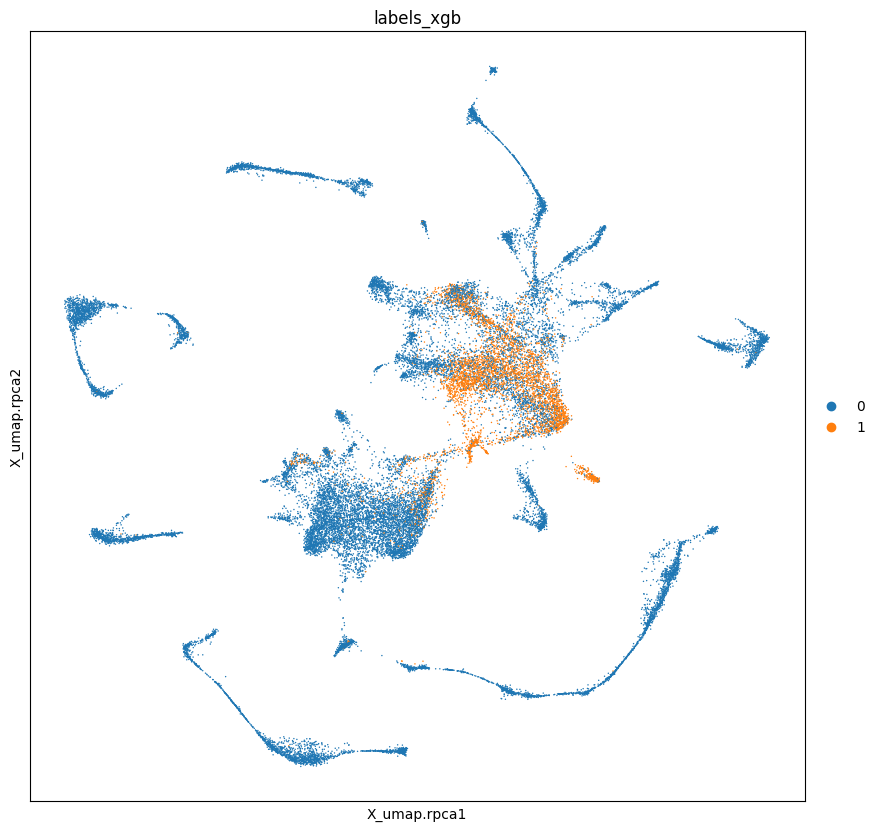

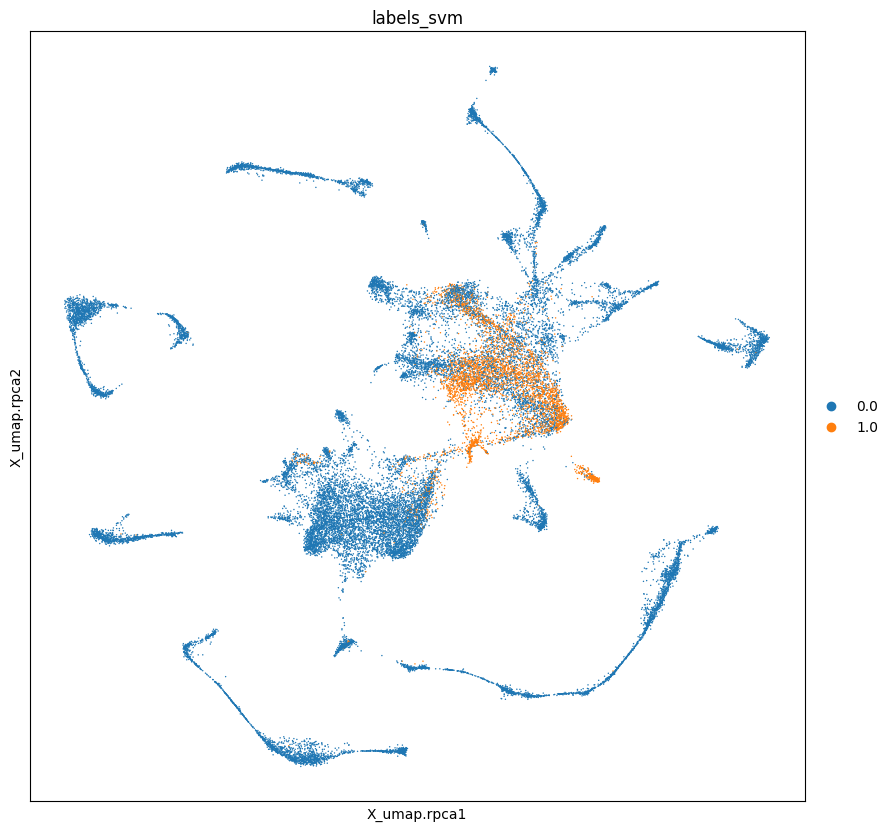

In [31]:
# Compare the results for each model
fig, ax = plt.subplots(1,1, figsize = (10,10))
# Plot umap with annotations using 4 colors for each annotation
# Change size of plot
sc.pl.embedding(merged, color='labels_xgb', basis='X_umap.rpca', ax = ax)

fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged, color='labels_svm', basis='X_umap.rpca',ax=ax)

In [31]:
# Actualize the annotation column in obs
# Add a v1 column in obs
annotation = []
v1 = []

for l, r in zip(merged.obs['labels_xgb'], merged.obs['training_labels']):
    if l == 1 and r == 1:
        annotation.append('GFP+')
        v1.append('V1')
    elif l == 1 and r == 0:
        annotation.append('V1_predicted')
        v1.append('V1')
    elif l == 1 and r == -1:
        annotation.append('V1_predicted')
        v1.append('V1')
    elif l == 0 and r == -1:
        annotation.append('Not_V1_predicted')
        v1.append('Not_V1')
    elif l == 0 and r == 0:
        annotation.append('GFP-')
        v1.append('Not_V1')
    elif l == 0 and r == 1:
        annotation.append('Not_V1_predicted')
        v1.append('Not_V1')
merged.obs['annotation'] = annotation
merged.obs['v1'] = v1

In [33]:
pd.DataFrame(annotation).value_counts()

0               
Not_V1_predicted    20529
GFP-                 3227
V1_predicted         2658
GFP+                 1807
Name: count, dtype: int64

In [45]:
merged.uns['annotation_colors'] = ['green', 'firebrick', 'mistyrose', 'lightgreen']

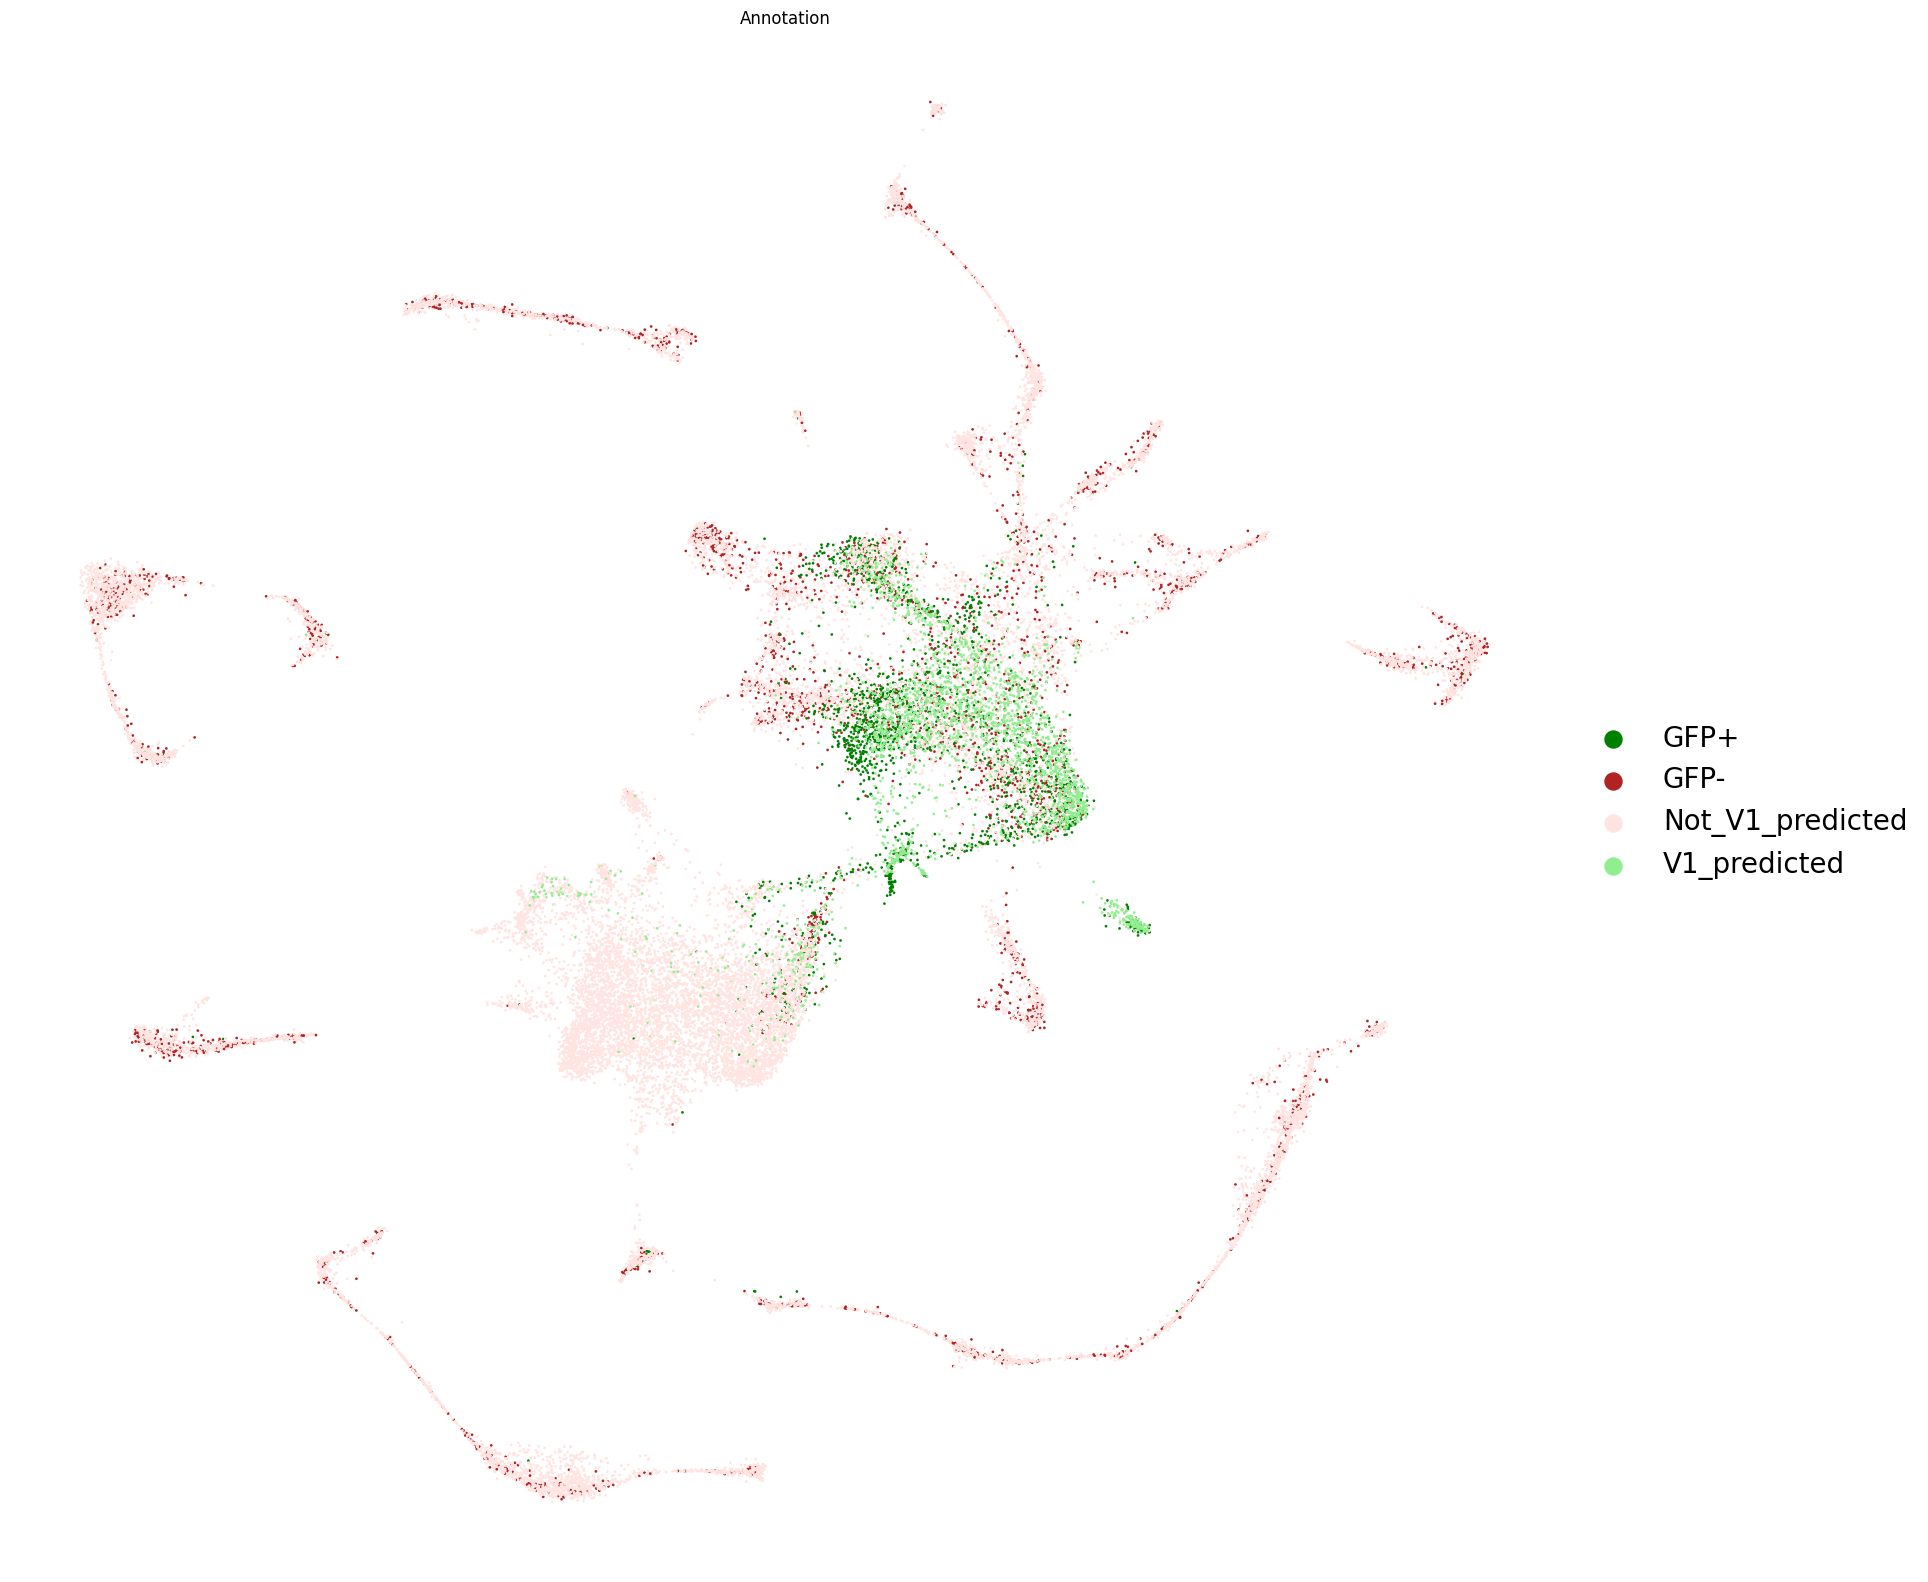

In [46]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
sc.pl.embedding(merged, color='annotation', basis='X_umap.rpca', ax = ax, save = '_mouse_cointegration_prediction.svg', size = 15, legend_fontsize=20, frameon=False, title = 'Annotation', legend_size=150)

In [36]:
merged.uns['v1_colors'] = ['yellow', 'blue']

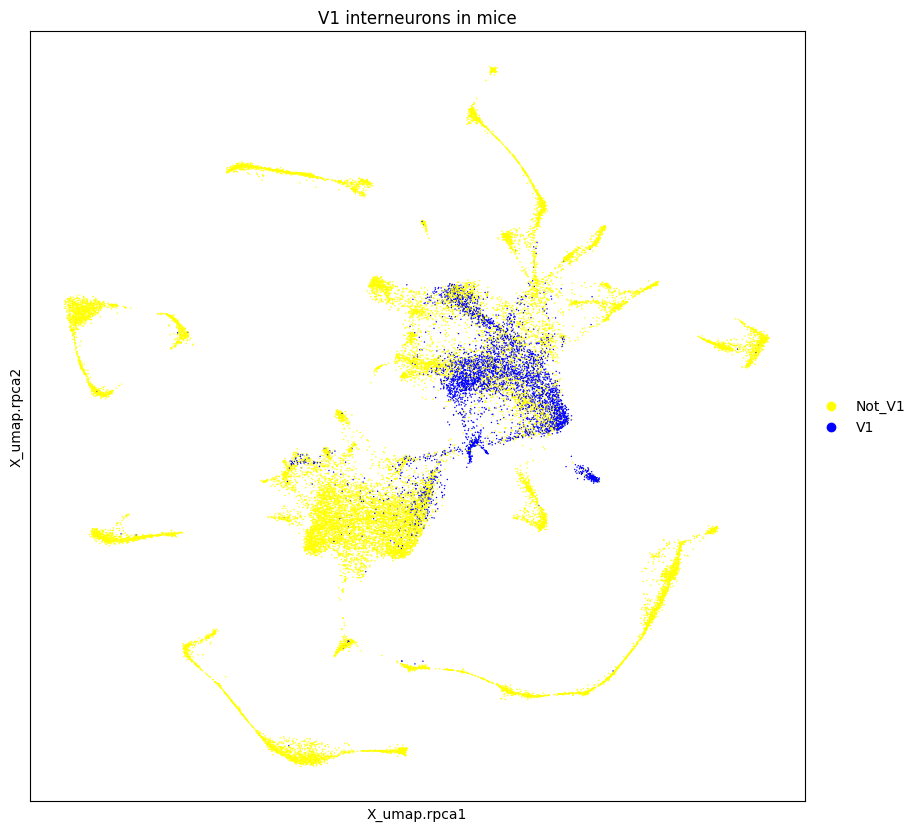

In [37]:
# Compare the results for each model
fig, ax = plt.subplots(1,1, figsize = (10,10))
# Plot umap with annotations using 4 colors for each annotation
# Change size of plot
sc.pl.embedding(merged, color='v1', basis='X_umap.rpca', ax = ax, title= 'V1 interneurons in mice')

In [38]:
merged.obs['v1'].value_counts()

v1
Not_V1    23756
V1         4465
Name: count, dtype: int64

In [39]:
merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()

C:\Users\Emile\AppData\Local\Temp\ipykernel_9624\2191423095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs['annotation'].groupby(merged.obs['orig.ident']).value_counts()


orig.ident  annotation      
BOUV5       Not_V1_predicted    1401
            V1_predicted          16
            GFP+                   0
            GFP-                   0
GSE7474501  Not_V1_predicted    3951
            V1_predicted         309
            GFP+                   0
            GFP-                   0
GSM7474503  Not_V1_predicted    6603
            V1_predicted         181
            GFP+                   0
            GFP-                   0
KATHE       Not_V1_predicted    2256
            V1_predicted          75
            GFP+                   0
            GFP-                   0
KNAF3       GFP-                3227
            V1_predicted          38
            GFP+                   0
            Not_V1_predicted       0
KNAF4       GFP+                1807
            Not_V1_predicted      13
            GFP-                   0
            V1_predicted           0
KNAF14      Not_V1_predicted    4066
            V1_predicted        1973
         

In [40]:
merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)

C:\Users\Emile\AppData\Local\Temp\ipykernel_9624\3651625991.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)


annotation,GFP+,GFP-,Not_V1_predicted,V1_predicted
orig.ident,,,,
BOUV5,0,0,1401,16
GSE7474501,0,0,3951,309
GSM7474503,0,0,6603,181
KATHE,0,0,2256,75
KNAF3,0,3227,0,38
KNAF4,1807,0,13,0
KNAF14,0,0,4066,1973
MATSON,0,0,2239,66


In [41]:
counts_xgb = merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)

C:\Users\Emile\AppData\Local\Temp\ipykernel_9624\2427307299.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_xgb = merged.obs.groupby(['orig.ident', 'annotation']).size().unstack(fill_value=0)


In [42]:
counts_xgb

annotation,GFP+,GFP-,Not_V1_predicted,V1_predicted
orig.ident,,,,
BOUV5,0,0,1401,16
GSE7474501,0,0,3951,309
GSM7474503,0,0,6603,181
KATHE,0,0,2256,75
KNAF3,0,3227,0,38
KNAF4,1807,0,13,0
KNAF14,0,0,4066,1973
MATSON,0,0,2239,66


In [43]:
def compute_props(counts):
    counts['V1_proportion'] = (counts['V1_predicted'] + counts['V1_CITEseq+']) / (counts['V1_predicted'] + counts['V1_CITEseq+'] + counts['CITEseq-'] + counts['Not_V1_predicted']) 
    return counts

In [44]:
compute_props(counts_xgb)

KeyError: 'V1_CITEseq+'

In [24]:
merged[merged.obs['orig.ident'] == 'KNAF14'].obs['predicted_annotation'].to_excel('knaf14_annotation.xlsx')

KeyError: 'predicted_annotation'

In [54]:
# Save the final merged data
merged.write(ROOT + "data/annotated_data/mouse_neurons+skinnider+knaf14.h5ad")

In [45]:
V1 = merged[merged.obs['v1'] == 'V1']

In [46]:
V1

View of AnnData object with n_obs × n_vars = 4465 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'doublet_finder', 'percent_mito', 'keep', 'nCount_SCT', 'nFeature_SCT', 'GFP', 'RNA_snn_res.2', 'seurat_clusters', 'training_labels', 'citeseq', 'annotation', 'labels_xgb', 'labels_svm', 'v1'
    var: 'vf_vst_counts.BOUV5_mean', 'vf_vst_counts.BOUV5_variance', 'vf_vst_counts.BOUV5_variance.expected', 'vf_vst_counts.BOUV5_variance.standardized', 'vf_vst_counts.BOUV5_variable', 'vf_vst_counts.BOUV5_rank', 'vf_vst_counts.KATHE_mean', 'vf_vst_counts.KATHE_variance', 'vf_vst_counts.KATHE_variance.expected', 'vf_vst_counts.KATHE_variance.standardized', 'vf_vst_counts.KATHE_variable', 'vf_vst_counts.KATHE_rank', 'vf_vst_counts.MATSON_mean', 'vf_vst_counts.MATSON_variance', 'vf_vst_counts.MATSON_variance.expected', 'vf_vst_counts.MATSON_variance.standardized', 'vf_vst_counts.MATSON_variable', 'vf_vst_counts.MATSON_rank', 'vf_vst_counts.KNAF3_mean', 'vf_vst_counts.KNAF3_varia

In [73]:
V1.write(ROOT + "data/annotated_data/mouse_V1.h5ad")

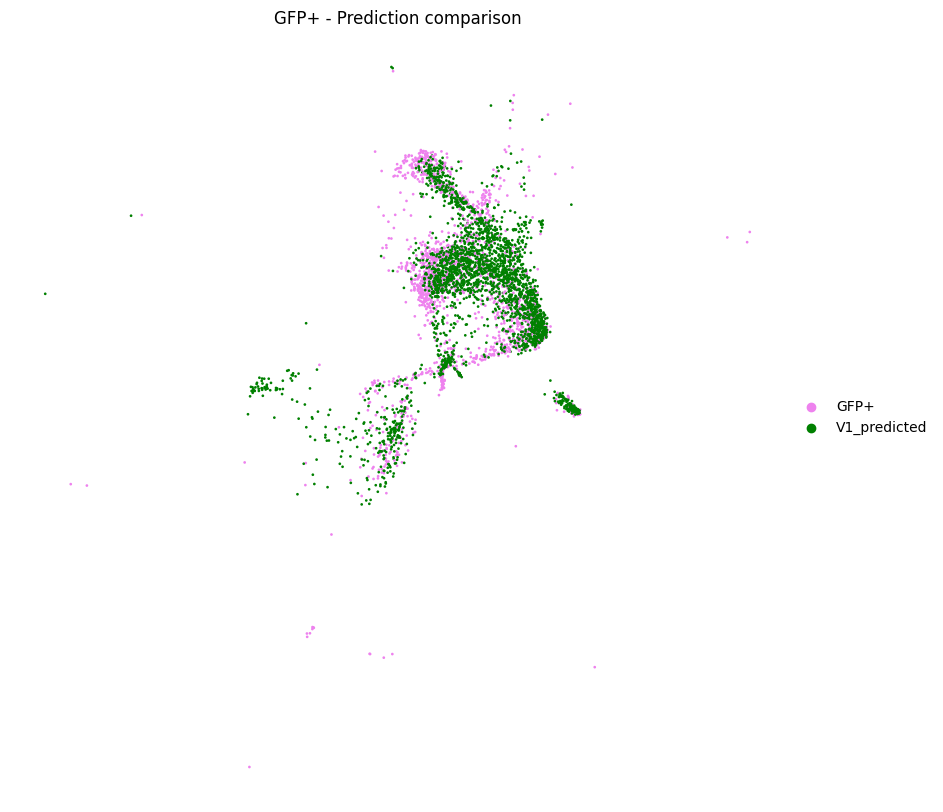

In [53]:
# plot the results
fig, ax = plt.subplots(1,1, figsize = (10,10))
sc.pl.embedding(merged[merged.obs['v1'] == 'V1'], color='annotation', basis='X_umap.rpca', ax = ax, size = 15, frameon=False, title = 'GFP+ - Prediction comparison', save = '_mouse_gfp_prediction_comparison.svg')